## DIP Assignment 4

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Task 1: Image Segmentation Using Thresholding

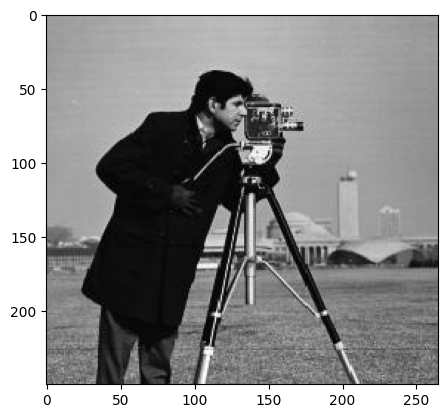

In [2]:
# load 1.png
img1 = cv2.imread("../data/1.png", cv2.IMREAD_GRAYSCALE)

plt.imshow(img1, cmap="gray")
plt.show()

In [ ]:
def binary_threshold(original, threshold):
    img = original.copy()
    
    img[img < threshold] = 0
    img[img >= threshold] = 255
    return img

In [ ]:
def adaptive_threshold_custom(original, block_size, C, method="mean"):
    image = original.copy()
    
    # Ensure block_size is odd
    if block_size % 2 == 0:
        raise ValueError("block_size must be an odd number.")

    # Compute local statistics
    if method == "mean":
        local_mean = cv2.boxFilter(image, ddepth=-1, ksize=(block_size, block_size))
        local_thresh = local_mean - C
    elif method == "median":
        local_thresh = cv2.medianBlur(image, block_size) - C
    else:
        raise ValueError("Method must be 'mean' or 'median'.")

    # Apply thresholding
    binary_image = (image > local_thresh).astype(np.uint8) * 255

    return binary_image

In [ ]:
def otsu_threshold(original):
    image = original.copy()
    
    # Flatten the image to calculate histogram
    pixel_values = image.ravel()
    hist, bin_edges = np.histogram(pixel_values, bins=256, range=(0, 256))
    
    # Calculate the cumulative sums and means
    total_pixels = pixel_values.size
    cumulative_sum = np.cumsum(hist)
    cumulative_mean = np.cumsum(hist * np.arange(256))
    global_mean = cumulative_mean[-1] / total_pixels  # Mean of the entire image
    
    # Compute between-class variance for each threshold
    between_class_variance = (
        (global_mean * cumulative_sum - cumulative_mean)**2 / 
        (cumulative_sum * (total_pixels - cumulative_sum) + 1e-10)  # Avoid division by zero
    )
    
    # Find the threshold that maximizes between-class variance
    optimal_threshold = np.argmax(between_class_variance)
    
    # Apply the threshold to create the binary image
    binary_image = (image > optimal_threshold).astype(np.uint8) * 255
    
    return optimal_threshold, binary_image

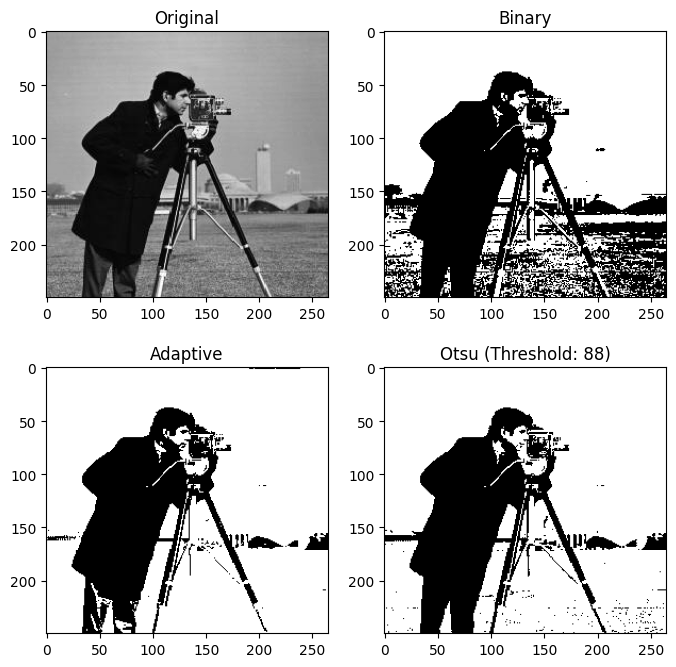

In [6]:
# binary thresholding
img1_binary = binary_threshold(img1, 128)

# adaptive thresholding
C = 55
block_size = 191
img1_adaptive = adaptive_threshold_custom(img1, block_size, C, method="median")

# Otsu's thresholding
optimal_threshold, binary_image = otsu_threshold(img1)

plt.figure(figsize=(8, 8))

plt.subplot(2, 2, 1)
plt.imshow(img1, cmap="gray")
plt.title(f"Original")

plt.subplot(2, 2, 2)
plt.imshow(img1_binary, cmap="gray")
plt.title(f"Binary")

plt.subplot(2, 2, 3)
plt.imshow(img1_adaptive, cmap="gray")
plt.title(f"Adaptive")

plt.subplot(2, 2, 4)
plt.imshow(binary_image, cmap='gray')
plt.title(f"Otsu (Threshold: {optimal_threshold})")

plt.show()

> (c) In 2-3 sentences, discuss which method provided the best segmentation for your image and why. Consider factors like clarity of object boundaries and noise levels.

Observations:
1. **Binary Thresholding:** Assigns pixels either a foreground or background value based on a global threshold, effective for high-contrast images but sensitive to lighting conditions. This method provided clear segmentation for regions with high contrast but struggled with areas of gradual intensity changes or noise.
2. **Adaptive Thresholding:** Calculates thresholds locally for different image regions, making it robust to varying illumination. It performed better on non-uniform lighting, as it calculates thresholds locally, resulting in more consistent segmentation across the image.
3. **Otsu’s Thresholding:** Automatically determines an optimal global threshold by minimizing intra-class variance of foreground and background pixel intensities, ideal for bimodal histograms. This method automatically determines the optimal threshold value, producing excellent results for images with bimodal histograms. However, it can be less effective if the histogram is unimodal or noisy.

Best Method: Adaptive Thresholding provided the best segmentation due to its robustness against uneven lighting, which preserved the clarity of object boundaries.

---
### Task 2: Line Detection Using Hough Transform

In [7]:
from math import sin, cos

In [8]:
img_building = cv2.imread("../data/building.jpg", cv2.IMREAD_COLOR)
img_building = cv2.resize(img_building, (img_building.shape[1]//2, img_building.shape[0]//2))


original_image = img_building
gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

edges = cv2.Canny(gray_image, 100, 500)

In [10]:
def compute_hough_space(edges, rho_resolution=1, theta_resolution=np.pi / 180):
    height, width = edges.shape
    diag_length = int(np.sqrt(height**2 + width**2))

    # Define rho and theta ranges
    num_rhos = 2 * diag_length // rho_resolution
    num_thetas = int(np.pi / theta_resolution)
    rhos = np.linspace(-diag_length, diag_length, num_rhos)
    thetas = np.linspace(-np.pi / 2, np.pi / 2, num_thetas)

    accumulator = np.zeros((num_rhos, num_thetas), dtype=np.uint64)
    y_idxs, x_idxs = np.nonzero(edges)  # Get edge coordinates

    # Populate the accumulator
    cos_thetas = np.cos(thetas)
    sin_thetas = np.sin(thetas)
    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]
        for theta_idx in range(num_thetas):
            rho = int(
                (x * cos_thetas[theta_idx] + y * sin_thetas[theta_idx]) / rho_resolution
                + diag_length
            )
            accumulator[rho, theta_idx] += 1

    return accumulator, rhos, thetas


def extract_lines(accumulator, rhos, thetas, threshold):
    lines = []
    for rho_idx in range(accumulator.shape[0]):
        for theta_idx in range(accumulator.shape[1]):
            if accumulator[rho_idx, theta_idx] > threshold:
                rho = rhos[rho_idx]
                theta = thetas[theta_idx]
                lines.append((rho, theta))
    return lines


def draw_detected_lines(image, lines, color=(0, 255, 0), thickness=2):
    result = image.copy()
    for rho, theta in lines:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(result, (x1, y1), (x2, y2), color, thickness)
    return result


def hough_line_detection(
    image, edges, rho_resolution=1, theta_resolution=np.pi / 180, threshold=100
):
    original_image = image.copy()
    edge = edges.copy()

    # Compute Hough space
    accumulator, rhos, thetas = compute_hough_space(
        edge, rho_resolution, theta_resolution
    )

    # Extract lines
    lines = extract_lines(accumulator, rhos, thetas, threshold)

    # Draw lines on the original image
    result = draw_detected_lines(original_image, lines)

    return result, edges, accumulator

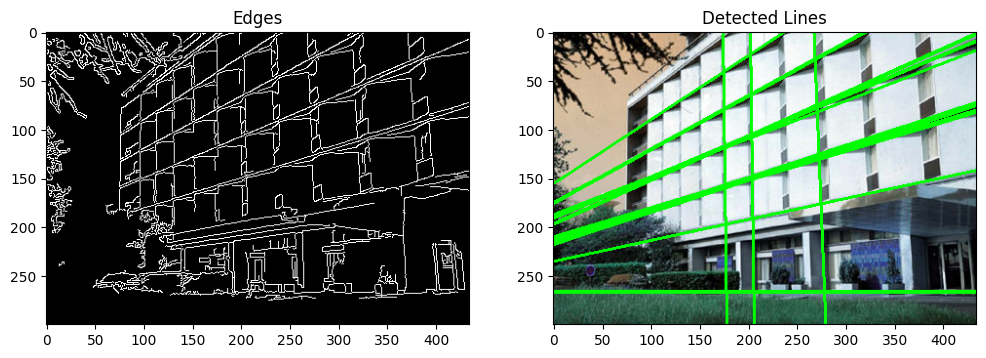

In [11]:
# Assuming `image` is loaded using cv2
detected_lines, edges, accumulator = hough_line_detection(
    img_building,
    edges, 
    rho_resolution=1, 
    theta_resolution=np.pi/120, 
    threshold=110
)

plt.figure(figsize=(12, 6))

# Display results
plt.subplot(1, 2, 1)
plt.title('Edges')
plt.imshow(edges, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Detected Lines')
plt.imshow(detected_lines, cmap='gray')
plt.show()


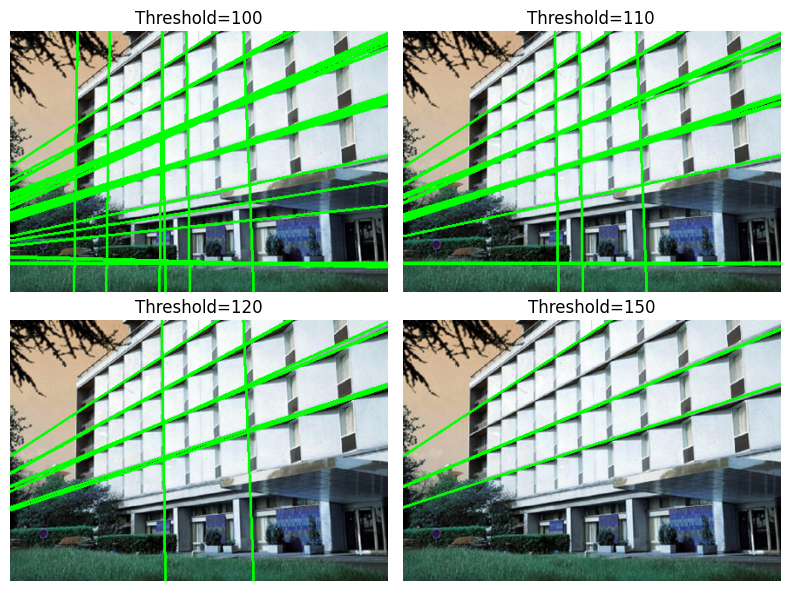

In [12]:
# Experiment with different threshold values
threshold_values = [100, 110, 120, 150]

fig, axes = plt.subplots(2, 2, figsize=(8, 6))

for idx, threshold in enumerate(threshold_values):
    original_image = img_building.copy()
    img = edges.copy()

    detected_lines, edges, accumulator = hough_line_detection(
        original_image,
        img, 
        rho_resolution=1, 
        theta_resolution=np.pi/120, 
        threshold=threshold
    )

    row, col = divmod(idx, 2)
    axes[row, col].imshow(detected_lines)
    axes[row, col].set_title(f"Threshold={threshold}")
    axes[row, col].axis("off")

plt.tight_layout()
plt.show()

- Accumulator threshold: Determines the minimum votes needed to confirm a line.

Increasing the accumulator threshold reduced noise and false positives but occasionally missed faint lines.
Lower thresholds detected weaker lines but introduced noise, especially in textured areas.
Parameter tuning (e.g., gap and length) helped optimize detection in broken or irregular line patterns.

The transform's performance depends heavily on parameter optimization. Preprocessing with Canny was essential for ensuring accurate line detection.

---
###Task 3: Circle Detection Using Hough CircleTransform

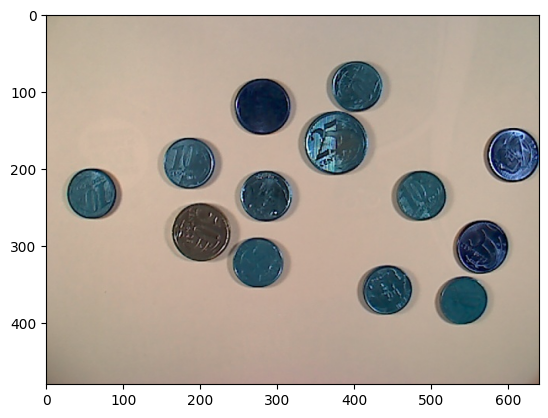

In [13]:
img_coins = cv2.imread("../data/coins.jpg", cv2.IMREAD_COLOR)
img_coins = cv2.cvtColor(img_coins, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img_coins, cv2.COLOR_BGR2GRAY)

plt.imshow(cv2.cvtColor(img_coins, cv2.COLOR_BGR2RGB))

In [14]:
from scipy import ndimage

Number of circles detected: 13


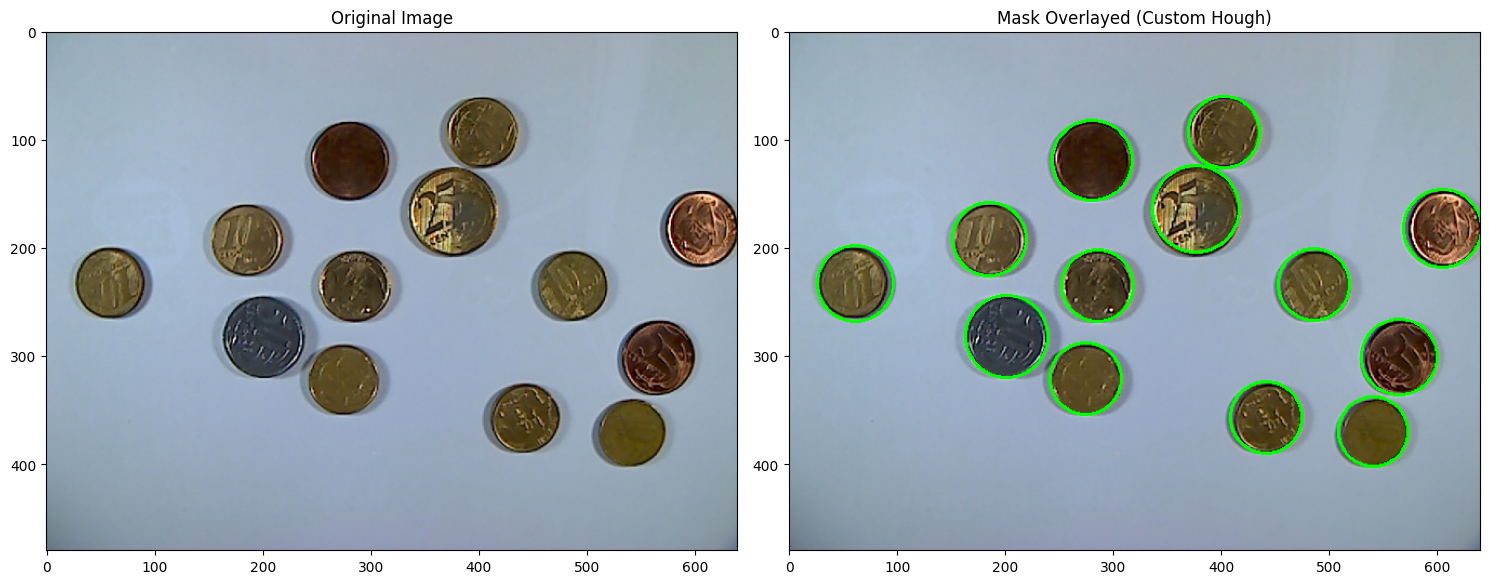

In [25]:
def initialize_accumulator(image_shape, dp, min_radius, max_radius):
    h, w = image_shape
    accumulator_h, accumulator_w = h // dp, w // dp
    radii = np.arange(min_radius, max_radius + 1)
    num_radii = len(radii)

    # Initialize accumulator array (height, width, number of radii)
    return np.zeros((accumulator_h, accumulator_w, num_radii), dtype=np.int32), radii


def accumulate_votes(edges, radii, dp, accumulator):
    y, x = np.where(edges > 0)

    # Precompute the sine and cosine values for all angles (0 to 2*pi)
    t = np.linspace(0, 2 * np.pi, 180)
    cos_t = np.cos(t)
    sin_t = np.sin(t)

    for i, r in enumerate(radii):
        x_offsets = (x[:, np.newaxis] - r * cos_t) / dp
        y_offsets = (y[:, np.newaxis] - r * sin_t) / dp

        x_idxs = np.floor(x_offsets).astype(int)
        y_idxs = np.floor(y_offsets).astype(int)

        # Valid indices within bounds
        valid = (
            (x_idxs >= 0)
            & (x_idxs < accumulator.shape[1])
            & (y_idxs >= 0)
            & (y_idxs < accumulator.shape[0])
        )
        np.add.at(accumulator, (y_idxs[valid], x_idxs[valid], i), 1)


def find_local_maxima(accumulator, threshold=100):
    local_max = (accumulator == ndimage.maximum_filter(accumulator, size=(3, 3, 3))) & (
        accumulator > threshold
    )
    return np.argwhere(local_max)


def filter_and_sort_circles(circles, min_dist):
    if circles.size > 0:
        # Sort circles by radius in descending order
        circles = circles[np.argsort(circles[:, 2])[::-1]]
        filtered_circles = []

        for circle in circles:
            if all(
                np.linalg.norm(circle[:2] - c[:2]) >= min_dist for c in filtered_circles
            ):
                filtered_circles.append(circle)

        return np.array(filtered_circles)
    return circles


def hough_circles(image, dp, minDist, threshold=100, minRadius=0, maxRadius=0):
    # Step 1: Apply edge detection
    edges = cv2.Canny(image, 50, 100)

    # Step 2: Initialize accumulator
    maxRadius = maxRadius or min(edges.shape) // 2
    minRadius = minRadius or 1
    accumulator, radii = initialize_accumulator(edges.shape, dp, minRadius, maxRadius)

    # Step 3: Accumulate votes
    accumulate_votes(edges, radii, dp, accumulator)

    # Step 4: Find local maxima in the accumulator
    local_max_coords = find_local_maxima(accumulator, threshold)

    # Step 5: Extract and filter circles
    circles = [(int(x * dp), int(y * dp), radii[r]) for y, x, r in local_max_coords]
    circles = np.array(circles)
    circles = filter_and_sort_circles(circles, minDist)

    return circles


def plot_results(img, result, circles):
    print("Number of circles detected:", circles.shape[0])

    plt.figure(figsize=(15, 15))
    plt.subplot(121)
    plt.imshow(img, cmap="gray")
    plt.title("Original Image")

    plt.subplot(122)
    plt.imshow(result, cmap="gray")
    plt.title("Mask Overlayed (Custom Hough)")

    plt.tight_layout()
    plt.show()


# Example usage
img = img_gray.copy()  # Replace with your actual grayscale image

_, img_thresholded = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Call custom Hough Circles function
circles = hough_circles(
    img_thresholded, dp=1, threshold=70, minDist=30, minRadius=30, maxRadius=40
)

# Create mask to visualize detected circles
output_img = img_coins.copy()
for circle in circles.astype(int):
    x, y, r = circle
    cv2.circle(output_img, (x, y), r, (0, 255, 0), 2)

# Plot the results
plot_results(img_coins, output_img, circles)

Varying thresholds

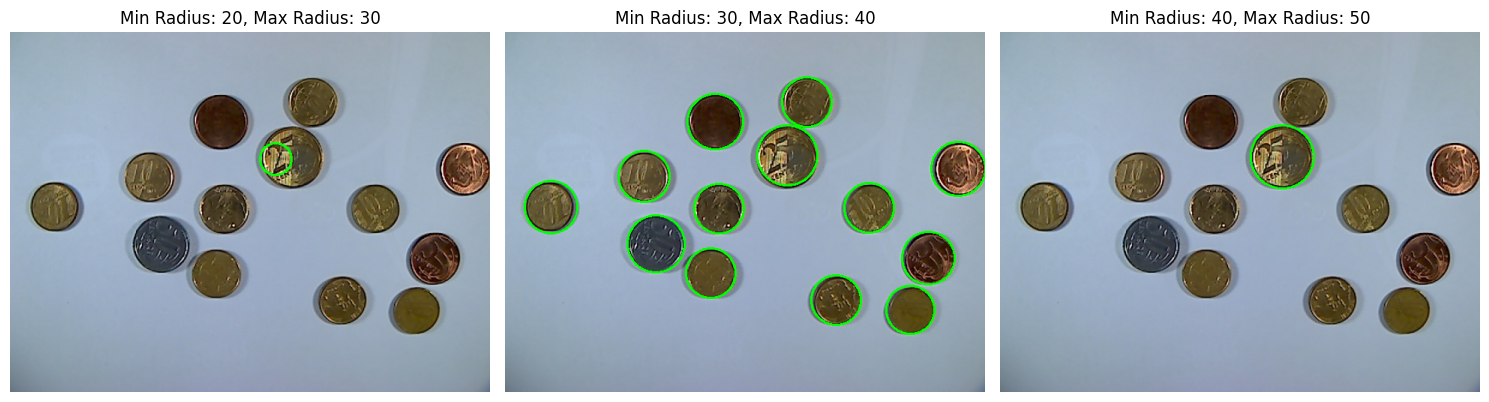

In [26]:
min_radii = [20, 30, 40] 
max_radii = [30, 40, 50]

fig, axes = plt.subplots(1, 3, figsize=(15, 10))

for idx, (min_radius, max_radius, threshold) in enumerate(zip(min_radii, max_radii, threshold_values)):
    circles = hough_circles(
        img_thresholded,
        dp=1,
        threshold=70,
        minDist=30,
        minRadius=min_radius,
        maxRadius=max_radius,
    )

    output_img = img_coins.copy()
    for circle in circles.astype(int):
        x, y, r = circle
        cv2.circle(output_img, (x, y), r, (0, 255, 0), 2)

    axes[idx % 3].imshow(output_img)
    axes[idx % 3].set_title(f"Min Radius: {min_radius}, Max Radius: {max_radius}")
    axes[idx % 3].axis("off")
    
plt.tight_layout()
plt.show()

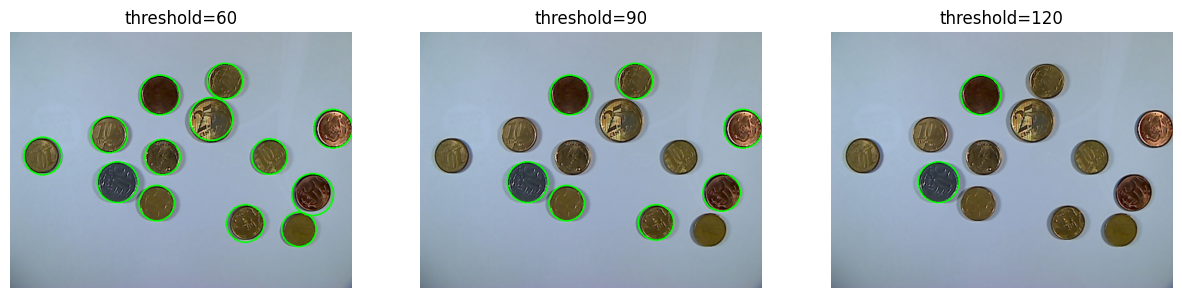

In [27]:
threshold_values = [60, 90, 120]

fig, axes = plt.subplots(1, 3, figsize=(15, 10))

for idx, threshold in enumerate(threshold_values):
    circles = hough_circles(
        img_thresholded,
        dp=1,
        threshold=threshold,
        minDist=30,
        minRadius=30,
        maxRadius=40,
    )

    output_img = img_coins.copy()
    for circle in circles.astype(int):
        x, y, r = circle
        cv2.circle(output_img, (x, y), r, (0, 255, 0), 2)

    axes[idx % 3].imshow(output_img)
    axes[idx % 3].set_title(f"threshold={threshold}")
    axes[idx % 3].axis("off")
    
plt.show() 

- Radius Ranges: Specifying appropriate radius ranges helped focus the detection on relevant features, avoiding false positives for non-circular objects.
- Accumulator Thresholds: Lowering the threshold detected more circles but introduced false detections, while higher thresholds ensured only strong candidates were identified.

Fine-tuning the radius range and accumulator thresholds helped strike a balance between accurate detection and noise minimization.

---
### Task 4: Harris Corner Detection

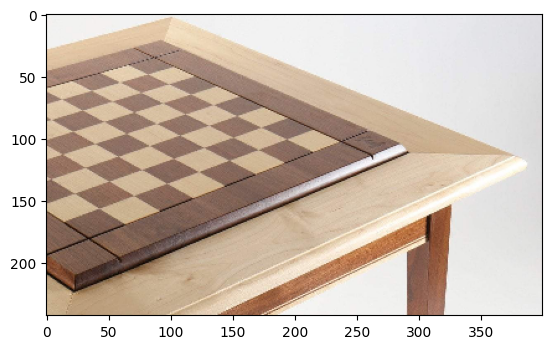

In [18]:
img_chess = cv2.imread("../data/chess.jpg", cv2.IMREAD_COLOR)
img_chess = cv2.cvtColor(img_chess, cv2.COLOR_BGR2RGB)
img_chess = cv2.resize(img_chess, (img_chess.shape[1]//3, img_chess.shape[0]//3))

plt.imshow(img_chess)

In [19]:
import cv2
import numpy as np

def harris_corner_detection(image, k=0.04, threshold=0.01, nms_window_size=5):
    """
        k (float): Sensitivity factor to separate corners from edges.
        threshold (float): Threshold for detecting corners.
        nms_window_size (int): Window size for non-maximum suppression.
    """
    gray = np.float32(image)

    # Compute gradients using Sobel
    Ix = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    Iy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

    # Compute products of derivatives and smooth them
    Ixx = cv2.GaussianBlur(Ix * Ix, (3, 3), 1)
    Iyy = cv2.GaussianBlur(Iy * Iy, (3, 3), 1)
    Ixy = cv2.GaussianBlur(Ix * Iy, (3, 3), 1)

    # Compute the Harris corner response
    det = (Ixx * Iyy) - (Ixy * Ixy)
    trace = Ixx + Iyy
    harris_response = det - k * (trace ** 2)

    # Threshold and Non-Maximum Suppression (NMS)
    corners = apply_threshold_and_nms(harris_response, threshold, nms_window_size)

    # Mark corners on the original image
    marked_image = mark_corners_on_image(image, corners)

    return marked_image, corners


def apply_threshold_and_nms(response, threshold, nms_window_size):
    
    # Threshold the response
    threshold_value = threshold * response.max()
    binary_response = (response > threshold_value).astype(np.uint8)

    # Non-Maximum Suppression (NMS)
    dilated_response = cv2.dilate(response, cv2.getStructuringElement(cv2.MORPH_RECT, (nms_window_size, nms_window_size)))
    nms_mask = (response == dilated_response) & (binary_response > 0)

    # Convert to binary image
    corners = (nms_mask).astype(np.uint8) * 255

    return corners


def mark_corners_on_image(image, corners):

    # Convert grayscale to BGR
    marked_image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    
    # Mark corners in red by putting a red circle over them
    for y, x in zip(*np.where(corners > 0)):
        cv2.circle(marked_image, (x, y), 2, (255, 0, 0), -1)
        

    return marked_image


In [20]:
image = img_chess.copy()

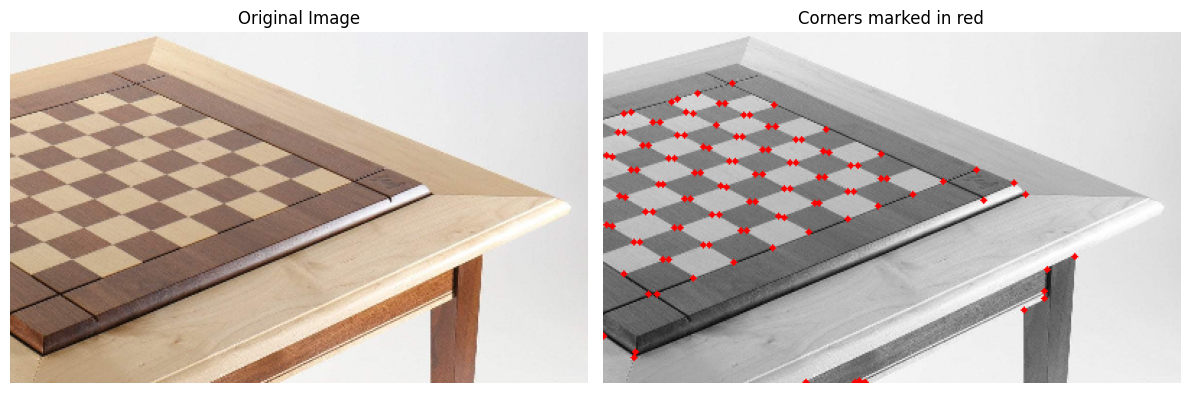

In [21]:
result, corners = harris_corner_detection(
    cv2.cvtColor(image, cv2.COLOR_RGB2GRAY),
    k=0.04,
    threshold=0.01,
    nms_window_size=5,
)
# Display the results
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(result)
axes[1].set_title("Corners marked in red")
axes[1].axis("off")

plt.tight_layout()
plt.show()

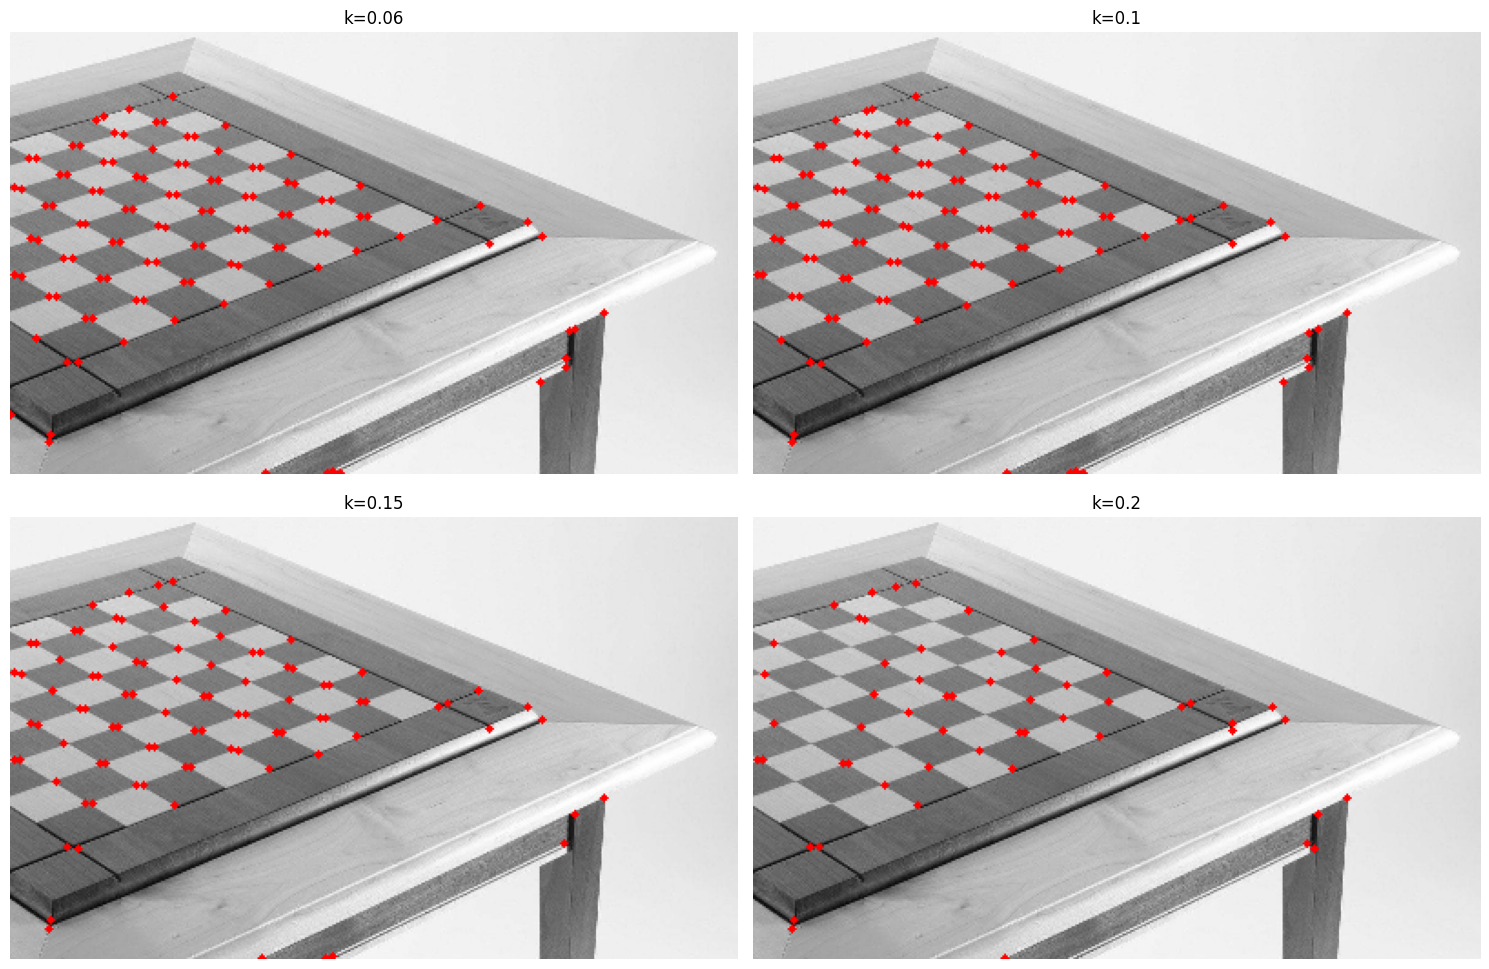

In [22]:
k_values = [0.06, 0.1, 0.15, 0.2]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for idx, k in enumerate(k_values):
    result, corners = harris_corner_detection(
        cv2.cvtColor(image, cv2.COLOR_RGB2GRAY),
        k=k,
        threshold=0.01,
        nms_window_size=5,
    )

    row, col = divmod(idx, 2)
    axes[row, col].imshow(result)
    axes[row, col].set_title(f"k={k}")
    axes[row, col].axis("off")
    
plt.tight_layout()  
plt.show()


- Lower values of k (e.g., 0.02) detected more corners, but some were less significant or noisy.
Higher values of k (e.g., 0.2) filtered out some corners.
- Marked corners aligned well with edges and junctions in the image, with the chessboard showing particularly strong corner responses.

Sensitivity to parameter k demonstrates a trade-off between detecting subtle features and avoiding noise. Optimal k depends on the image's characteristics.

---
### Task 5: Short Theory
Explain how the Hough Transform differs when detecting
lines versus circles in an image. Discuss how parameter space and computational complexity vary between these applications.

The Hough Transform uses a parameter space to detect shapes by mapping image points into curves or surfaces. For line detection, each edge point maps to a sinusoidal curve in 2D (ρ and θ space), where intersections represent lines. For circle detection, the parameter space is 3D (x, y, and radius), as each edge point contributes to a circular trajectory depending on its radius.


<br>

### 1. Parameter Space
> Lines <br>


A line in 2D can be represented using the parametric form:
$$
r=xcosθ+ysinθ
$$
`r`: Perpendicular distance from the origin to the line.

`θ`: Angle of the perpendicular line with respect to the horizontal axis.

- Parameter Space: The Hough Transform for lines maps each point $(x,y)$ in the image to a sinusoidal curve in the $(r,θ)$ parameter space. The intersections of curves in this space indicate the presence of a line.

- Dimensionality: 2D parameter space ($r$ and $θ$).

<br>

> Circles <br>


A circle can be represented by its parametric equation:
$$
(x−a)^2 +(y−b)^2 = r^2
$$
`(a,b)`: Coordinates of the circle's center.

`r`: Radius of the circle.

- Parameter Space: The Hough Transform for circles involves detecting potential centers $(a,b)$ and radius $r$. Each edge point $(x,y)$ maps to a cone in a 3D parameter space, representing possible circle centers and radii.

- Dimensionality: 3D parameter space $(a, b, r)$.


<br>

### 2. Computational Complexity
> Lines <br>

- Complexity is lower due to the 2D parameter space.
- Requires less memory and computational resources.
- Accumulator array: 2D grid for (r,θ).

> Circles <br>

- Complexity is significantly higher due to the 3D parameter space.
- Requires more memory and computational resources to handle the additional parameter ($r$) and larger accumulator matrix.
- Accumulator array: 3D grid for $(a,b,r)$, which increases the size of the parameter space exponentially with radius range.
